In [1]:
%load_ext autoreload
%autoreload 2

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import math
import statsmodels.api as sm

from statsmodels.tsa.stattools import adfuller

from cpi_prediction.data.data_retriever import DataRetriever
from cpi_prediction.data.data_preprocessor import DataPreprocessor
from cpi_prediction.model.model import ARIMAModel
from cpi_prediction.config import START_DATE, END_DATE, DB, TABLE, Y, EXOG
from cpi_prediction.detrender import Detrender

In [2]:
sns.set_theme(style="darkgrid")

def plot(x: np.ndarray, y: np.ndarray, label: str) -> None:
    fig, ax = plt.subplots(figsize=(20, 8), dpi=300)
    step = int(math.ceil(len(x) / 40))
    ax.plot(x, y, '-', color='black', label=label)
    plt.xticks(x[::step])
    ax.tick_params(axis='x', rotation=45)
    ax.set_ylabel(label)
    ax.set_xlabel("dt")
    plt.show()

In [3]:
dr = DataRetriever(
    db=DB,
    start_dt=START_DATE,
    end_dt=END_DATE
)
data = dr.retrieve()
data

,date,value,series
0,1999-01-01,164.70,CPIAUCSL
1,1999-02-01,164.70,CPIAUCSL
2,1999-03-01,164.80,CPIAUCSL
3,1999-04-01,165.90,CPIAUCSL
4,1999-05-01,166.00,CPIAUCSL
...,...,...,...
880,2023-03-01,73.28,MCOILWTICO
881,2023-04-01,79.45,MCOILWTICO
882,2023-05-01,71.58,MCOILWTICO
883,2023-06-01,70.25,MCOILWTICO


In [4]:
dp = DataPreprocessor(data)
processed_df = dp.preprocess()
processed_df

series,CPIAUCSL,FEDFUNDS,MCOILWTICO,ln_CPIAUCSL,d_ln_CPIAUCSL,l_d_ln_CPIAUCSL,ln_FEDFUNDS,d_ln_FEDFUNDS,l_d_ln_FEDFUNDS,ln_MCOILWTICO,d_ln_MCOILWTICO,l_d_ln_MCOILWTICO
date,,,,,,,,,,,,
1999-03,164.800,4.81,14.68,5.104733,0.100,0.000,1.570697,0.05,0.13,2.686486,2.67,-0.51
1999-04,165.900,4.74,17.31,5.111385,1.100,0.100,1.556037,-0.07,0.05,2.851284,2.63,2.67
1999-05,166.000,4.74,17.72,5.111988,0.100,1.100,1.556037,0.00,-0.07,2.874694,0.41,2.63
1999-06,166.000,4.76,17.92,5.111988,0.000,0.100,1.560248,0.02,0.00,2.885917,0.20,0.41
1999-07,166.700,4.99,20.10,5.116196,0.700,0.000,1.607436,0.23,0.02,3.000720,2.18,0.20
...,...,...,...,...,...,...,...,...,...,...,...,...
2023-03,301.808,4.65,73.28,5.709791,0.160,1.112,1.536867,0.08,0.24,4.294288,-3.55,-1.29
2023-04,302.918,4.83,79.45,5.713462,1.110,0.160,1.574846,0.18,0.08,4.375128,6.17,-3.55
2023-05,303.294,5.06,71.58,5.714703,0.376,1.110,1.621366,0.23,0.18,4.270816,-7.87,6.17


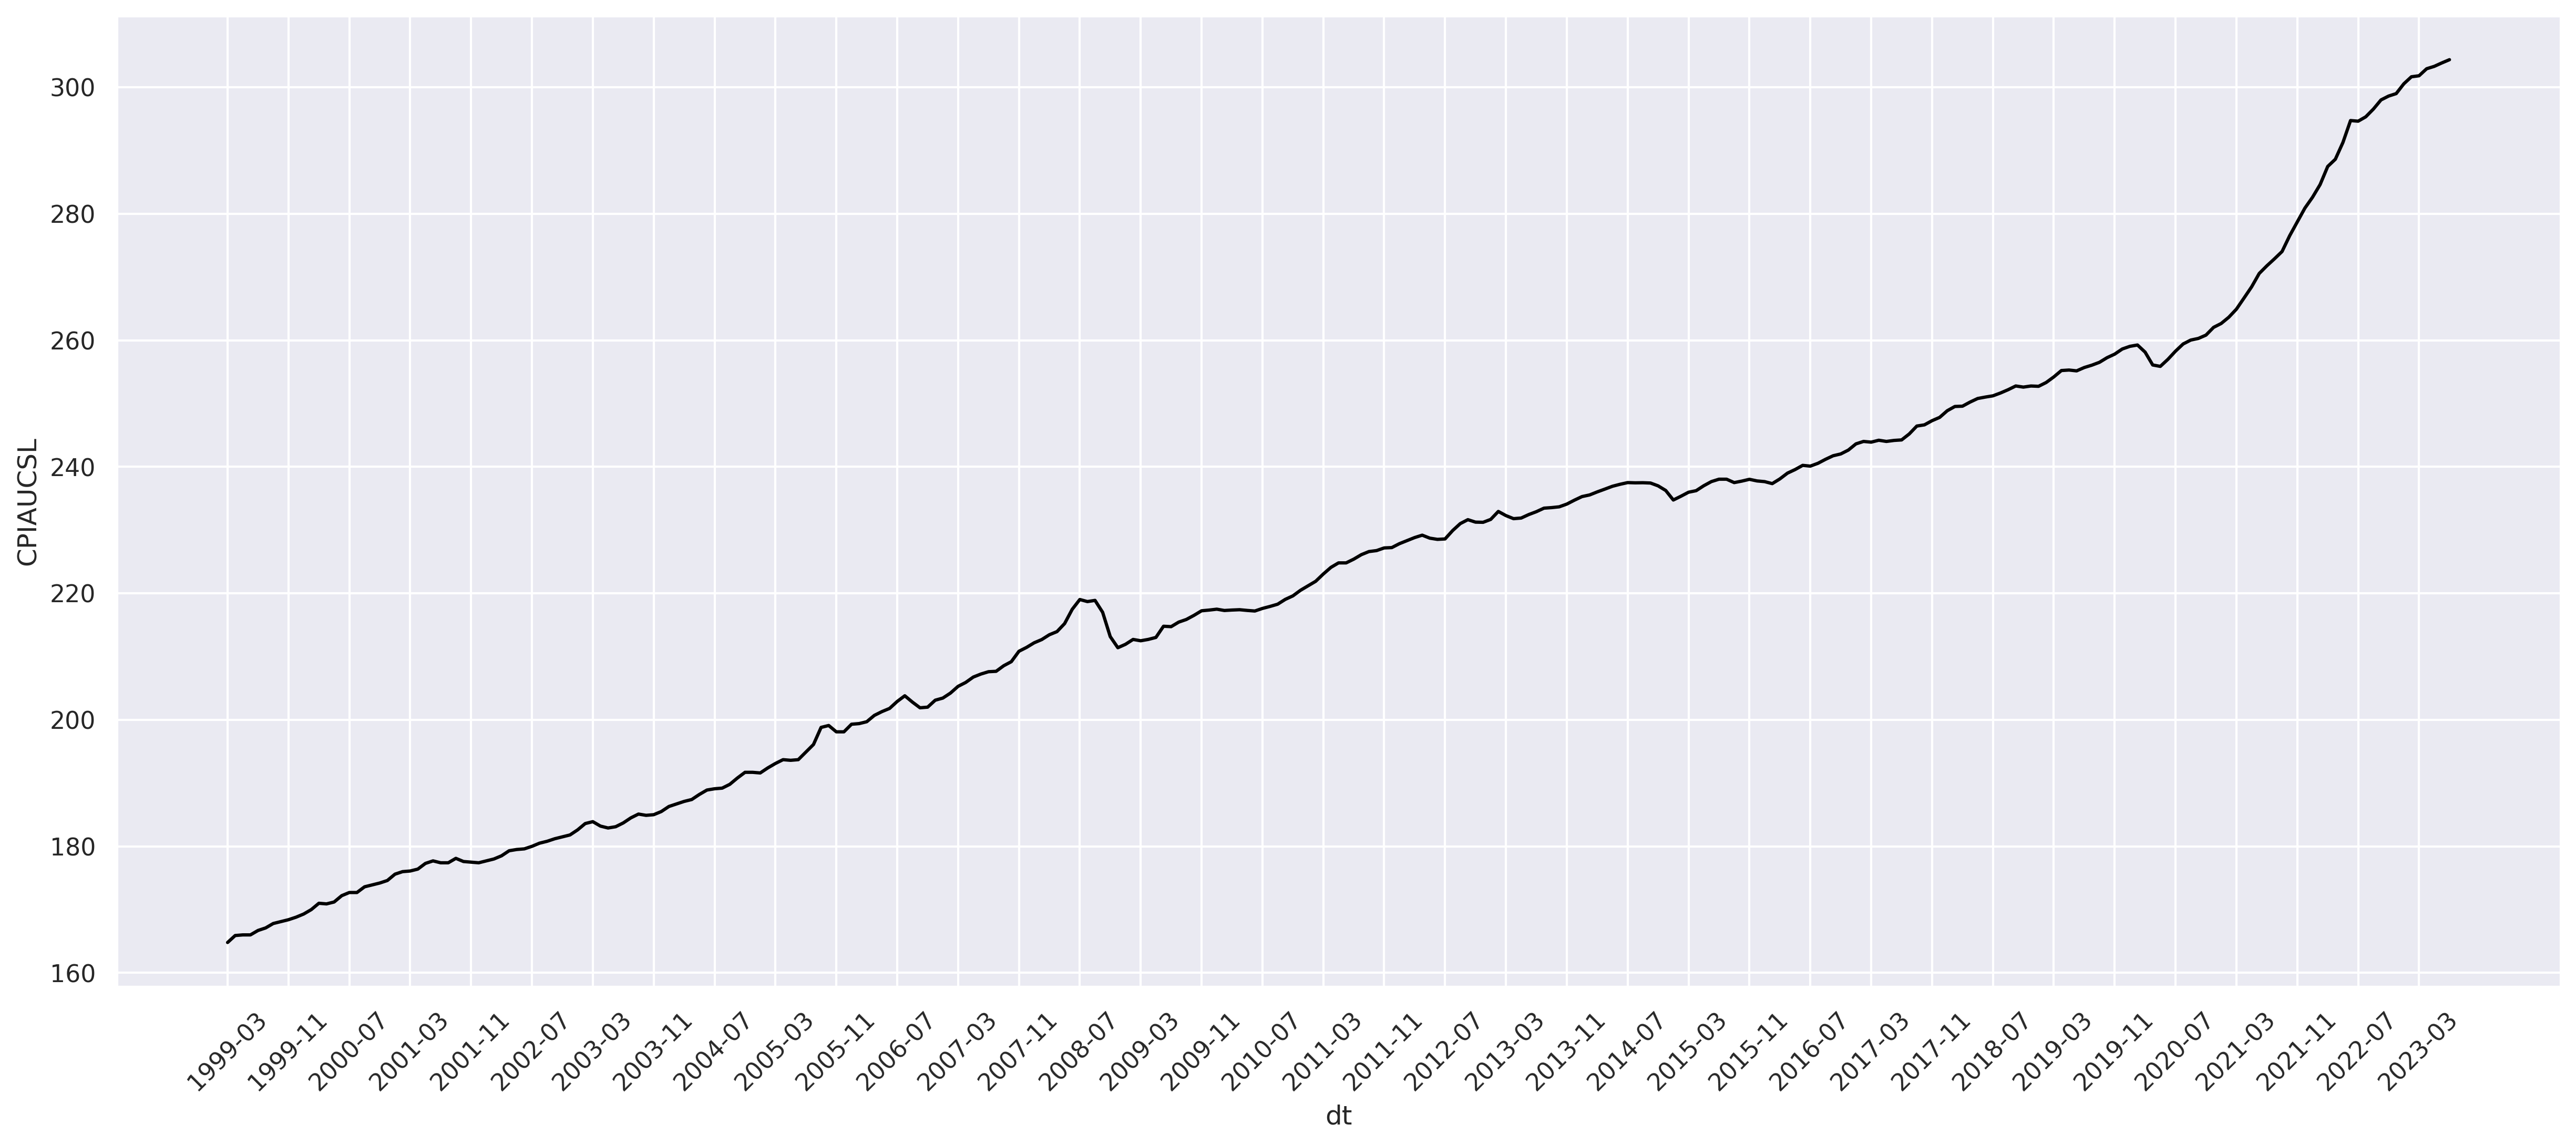

In [5]:
 # Step 1 - Trend
 plot(
  x=processed_df.index.strftime("%Y-%m"), 
  y=processed_df.loc[:, Y].values, 
  label=f"{Y}"
)

In [6]:

processed_df['time'] = np.arange(1, len(processed_df.index)+1)
processed_df['time_squared'] = processed_df['time'] ** 2

y = processed_df.loc[:, Y]
X = processed_df.loc[:, ['time', 'time_squared']]
X = sm.add_constant(X)
model = sm.OLS(y,X)
results = model.fit()
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:               CPIAUCSL   R-squared:                       0.970
Model:                            OLS   Adj. R-squared:                  0.970
Method:                 Least Squares   F-statistic:                     4750.
Date:                Tue, 29 Aug 2023   Prob (F-statistic):          2.39e-222
Time:                        18:53:00   Log-Likelihood:                -936.84
No. Observations:                 293   AIC:                             1880.
Df Residuals:                     290   BIC:                             1891.
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
================================================================================
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
const          168.8372      1.050    160.766      0.000     166.770     170.904
time             0.3061      0.016     18.554      0.000       0.274       0.339
time_squared     0.0003   5.43e-05      5.877      0.000       0.000       0.000
==============================================================================
Omnibus:                       42.753   Durbin-Watson:                   0.014
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               62.285
Skew:                           0.913   Prob(JB):                     2.99e-14
Kurtosis:                       4.330   Cond. No.                     1.16e+05
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 1.16e+05. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [7]:
processed_df[f"{Y}_detrended"] = (
    processed_df[Y] 
    - results.params[0] 
    - results.params[1] * processed_df['time']
    - results.params[2] * processed_df['time_squared']
)
b0, b1, b2 = results.params[0], results.params[1], results.params[2]
processed_df[f"d_{Y}_detrended"] = processed_df[f"{Y}_detrended"].diff()
processed_df[f"d2_{Y}_detrended"] = processed_df[f"d_{Y}_detrended"].diff()

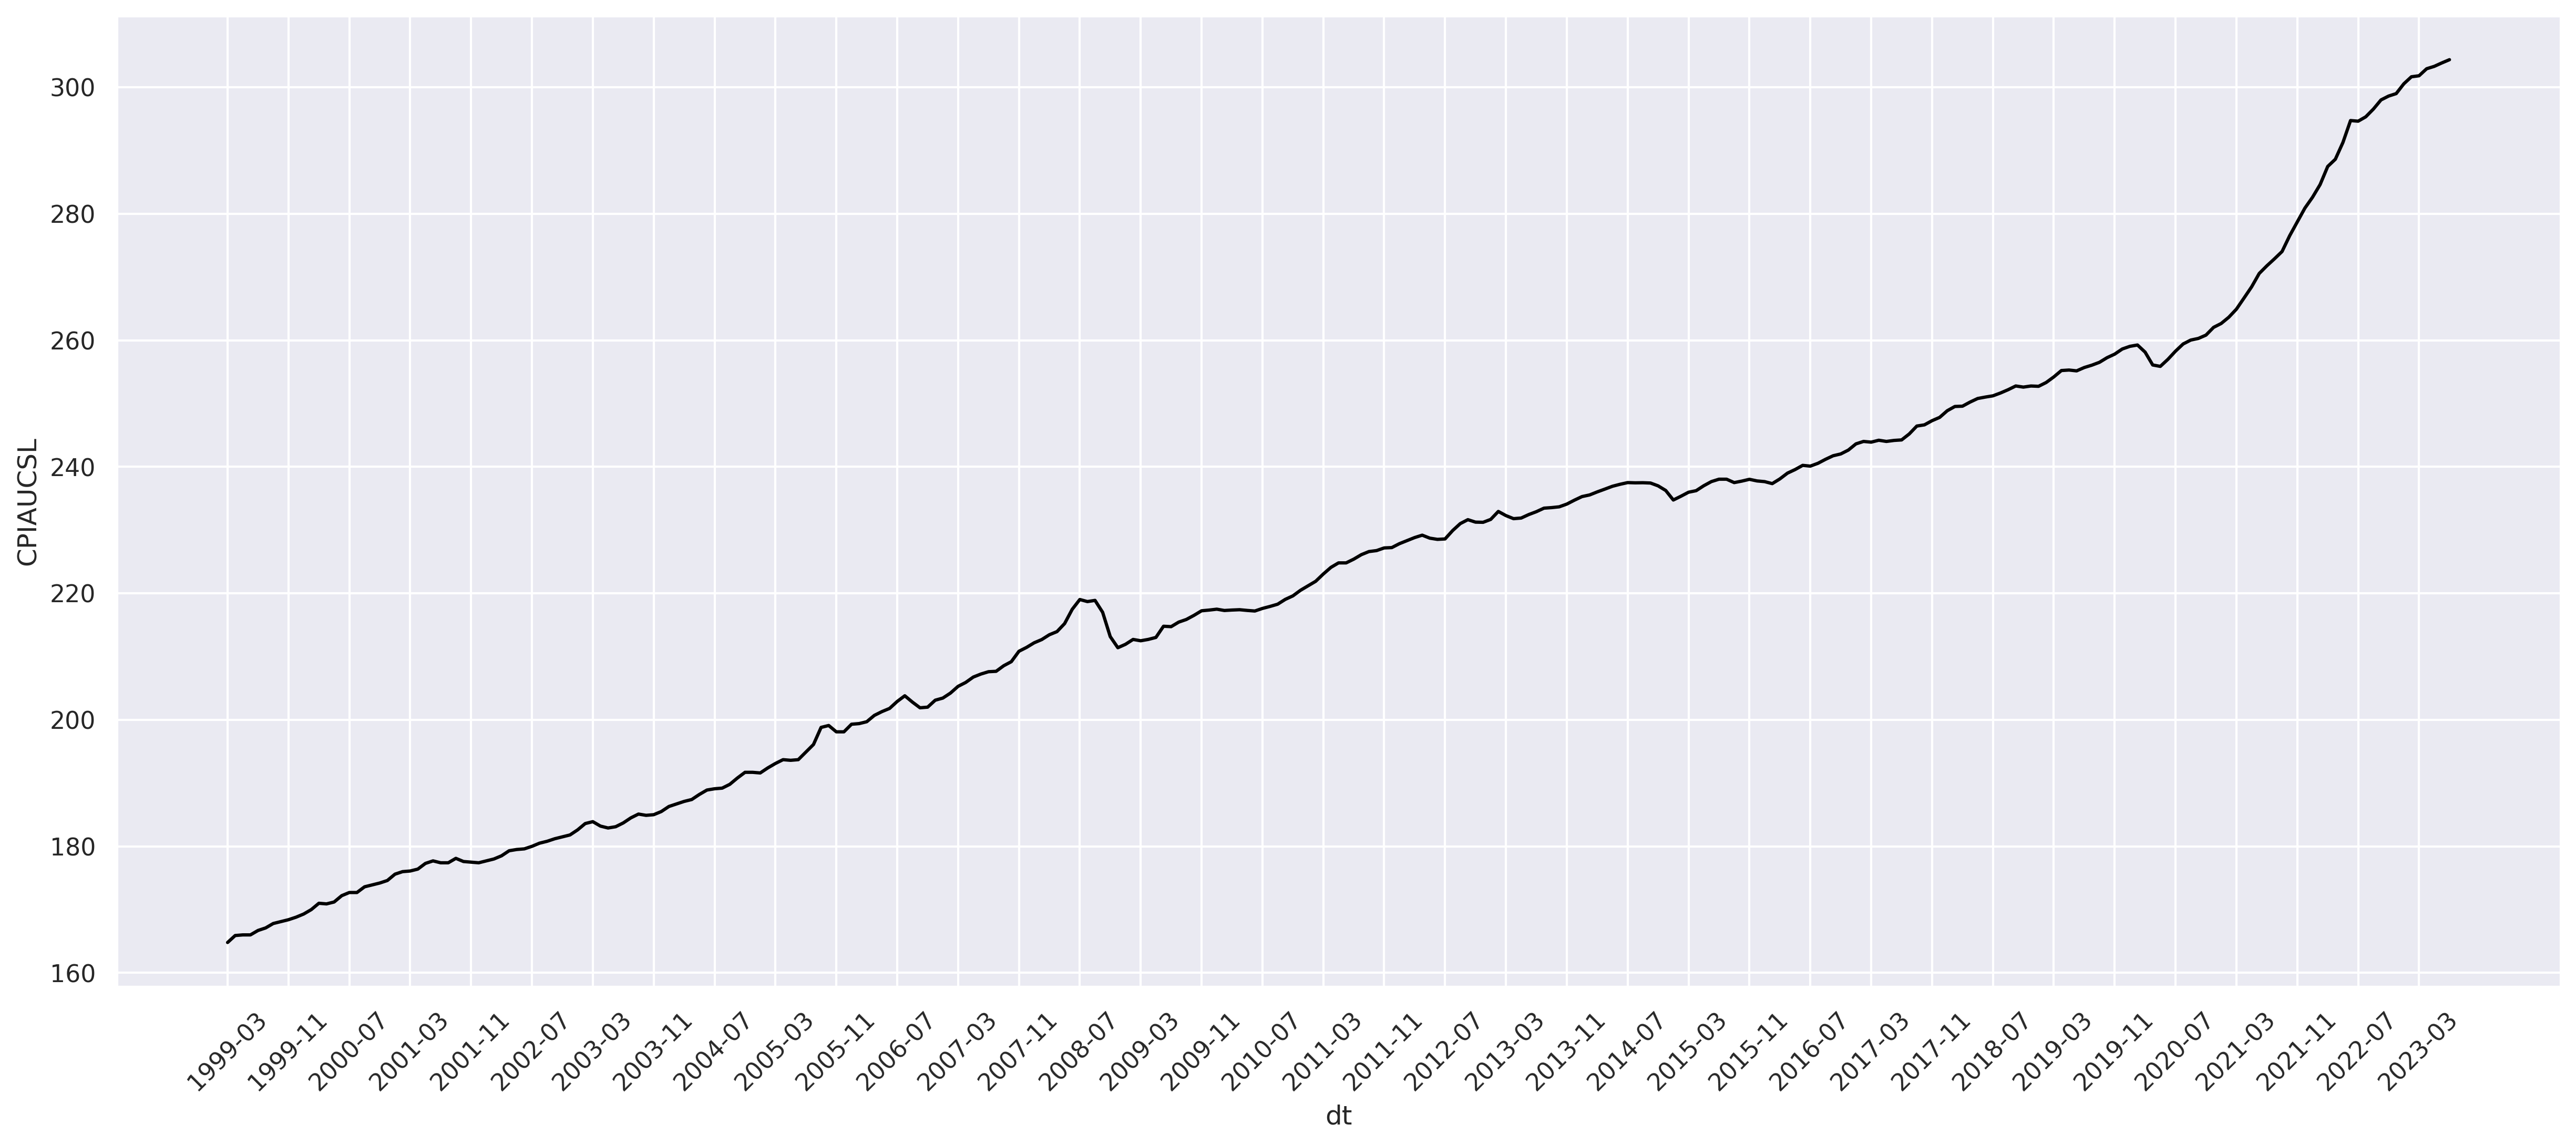

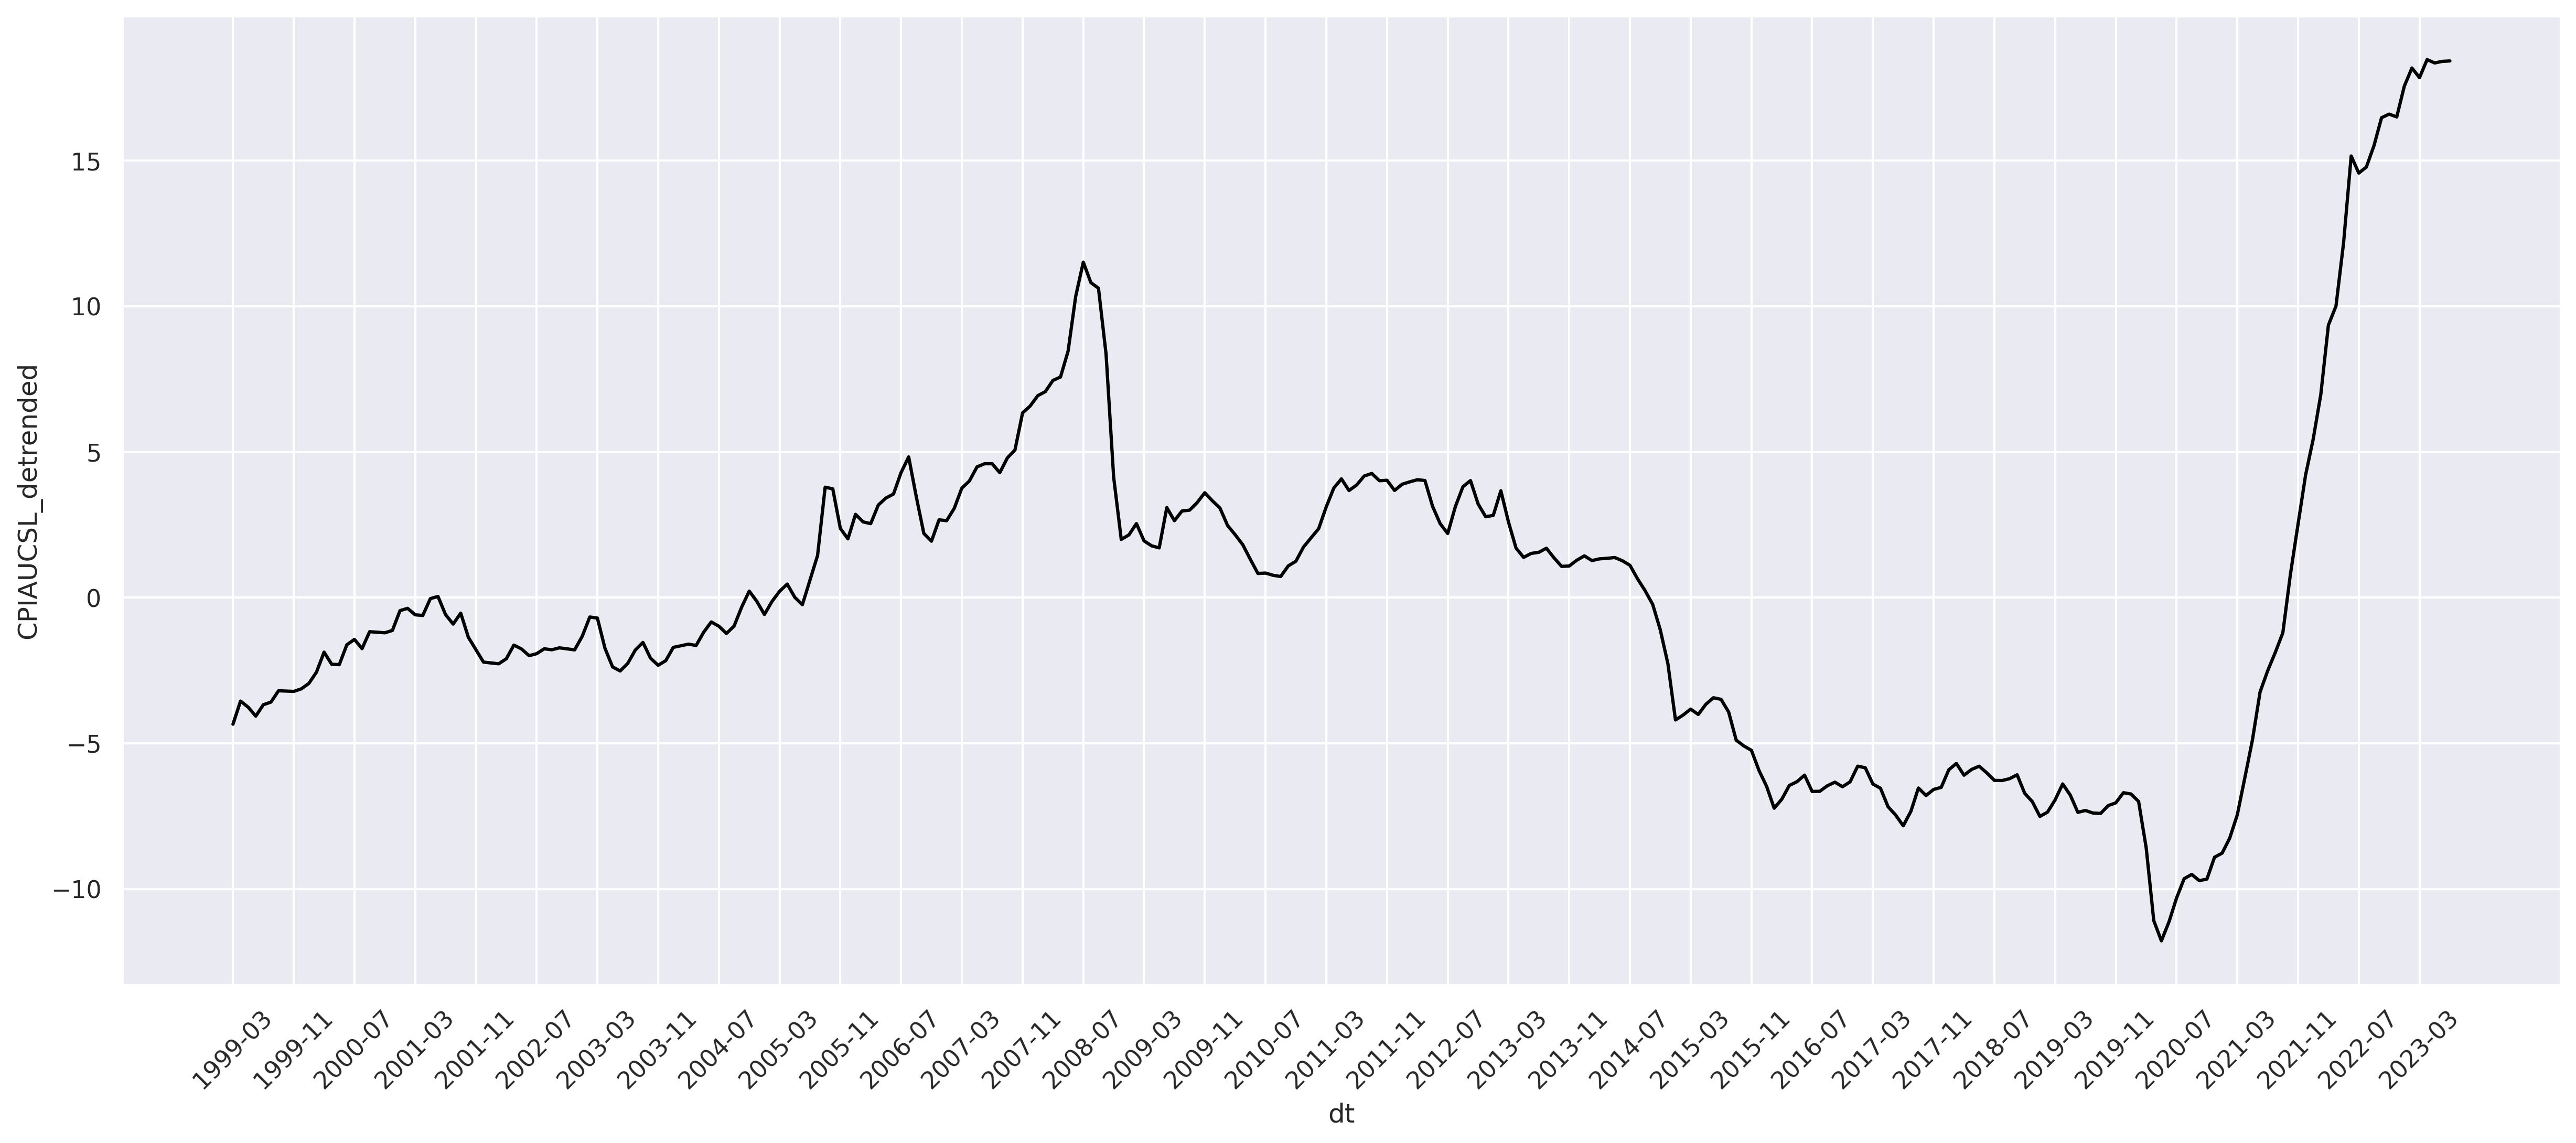

In [8]:
columns = [Y, f"{Y}_detrended"]
for c in columns:
    plot(
        x=processed_df.index.strftime("%Y-%m"), 
        y=processed_df[c].values, 
        label=c
    )

In [9]:
# Step 2 - Stationarity I(d) in ARIMA
rows = []
for c in processed_df.columns:
    y = processed_df[c][~np.isnan(processed_df[c])]
    adf_result = adfuller(y)
    row = {
        'series': c,
        'ADF_statistic': adf_result[0],
        'ADF_pvalue': round(adf_result[1],4),
        'ADF_critical_value_1%': adf_result[4]['1%'],
        'ADF_critical_value_5%': adf_result[4]['5%'],
        'ADF_critical_value_10%': adf_result[4]['10%']
    }
    rows.append(row)
results_df = pd.DataFrame(rows)
results_df

/home/marcin/miniconda3/lib/python3.9/site-packages/statsmodels/regression/linear_model.py:956: RuntimeWarning: divide by zero encountered in log
  llf = -nobs2*np.log(2*np.pi) - nobs2*np.log(ssr / nobs) - nobs2


,series,ADF_statistic,ADF_pvalue,ADF_critical_value_1%,ADF_critical_value_5%,ADF_critical_value_10%
0,CPIAUCSL,1.279463,0.9965,-3.454180,-2.872031,-2.572360
1,FEDFUNDS,-3.027291,0.0324,-3.453342,-2.871664,-2.572164
2,MCOILWTICO,-2.863401,0.0498,-3.453023,-2.871524,-2.572090
3,ln_CPIAUCSL,0.730396,0.9904,-3.453922,-2.871918,-2.572300
4,d_ln_CPIAUCSL,-2.642627,0.0845,-3.454094,-2.871993,-2.572340
5,l_d_ln_CPIAUCSL,-2.580252,0.0971,-3.454094,-2.871993,-2.572340
6,ln_FEDFUNDS,-2.125869,0.2342,-3.453342,-2.871664,-2.572164
7,d_ln_FEDFUNDS,-3.798138,0.0029,-3.453262,-2.871628,-2.572146
8,l_d_ln_FEDFUNDS,-3.742514,0.0036,-3.453262,-2.871628,-2.572146
9,ln_MCOILWTICO,-2.851794,0.0512,-3.453102,-2.871559,-2.572108


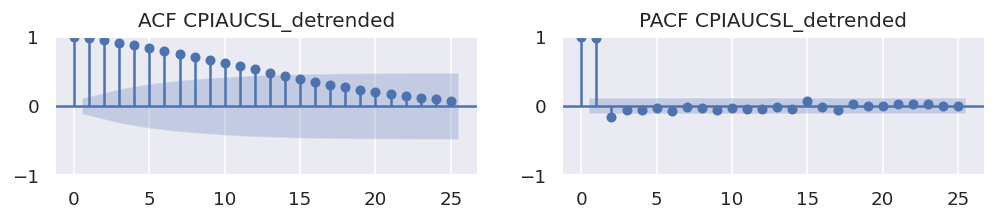

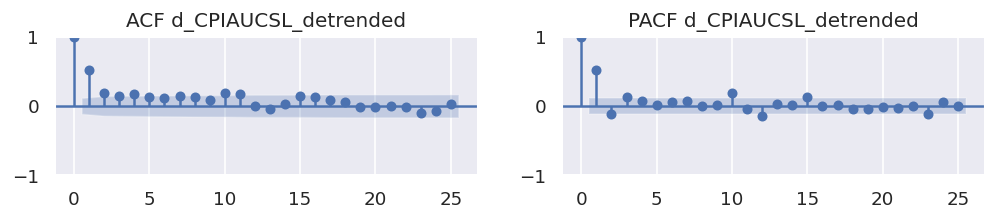

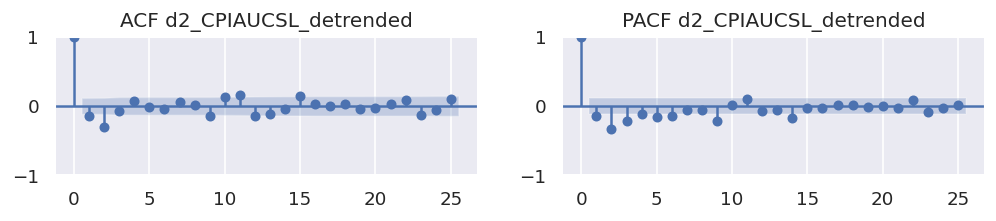

In [10]:
# Step 3 - Correlogram for determining AR(p) and MA(q) components in ARIMA
series = [f"{Y}_detrended", f"d_{Y}_detrended", f"d2_{Y}_detrended"]
plt.rcParams.update({'figure.figsize':(10,1.5), 'figure.dpi':120})
for s in series:
    fig, axes = plt.subplots(1, 2, sharex=False)
    sm.graphics.tsa.plot_acf(processed_df[s].dropna(), ax=axes[0], title=f"ACF {s}")
    sm.graphics.tsa.plot_pacf(processed_df[s].dropna(), ax=axes[1], title=f"PACF {s}")

In [11]:
# Step 4 - time-series cross-validation for picking p,d,q 
K = 40
N = len(processed_df)
results = []
for p in [0, 1, 2]:
    for d in [1, 2]:
        for q in [0, 1, 2]:
            residuals = []
            aic_values = []
            for k in range(1, K):
                y = processed_df.iloc[:N-K+k, processed_df.columns.get_loc(Y)].values
                dt = Detrender()
                dt.fit(y)
                y_detrended = dt.transform(y)
                y_test = processed_df.iloc[N-K+k:N-K+k+1, processed_df.columns.get_loc(Y)].values.item()
                mod = ARIMAModel(p, d, q)
                res = mod.fit(y_detrended)
                t = len(y)
                y_test_hat = mod.predict() + (dt.coef_[0] + dt.coef_[1]*(t+1) + dt.coef_[2]*(t+1)**2)
                e = y_test - y_test_hat
                residuals.append(e)
                aic = mod.get_aic()
                aic_values.append(aic)
            rmse = math.sqrt(np.mean(np.array(residuals)**2))
            maic = np.mean(aic_values)
            result = {
                'p': p,
                'd': d,
                'q': q,
                'rmse': rmse,
                'maic': maic
            }
            results.append(result)
results_df = pd.DataFrame(results).sort_values(by='rmse', ascending=True)
results_df

/home/marcin/miniconda3/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/home/marcin/miniconda3/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/home/marcin/miniconda3/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/home/marcin/miniconda3/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/home/marcin/miniconda3/lib/

,p,d,q,rmse,maic
15,2,2,0,0.842203,525.756199
5,0,2,2,0.871625,476.707037
10,1,2,1,0.873402,484.216298
4,0,2,1,0.876949,536.893901
11,1,2,2,0.877593,475.389900
17,2,2,2,0.894088,475.186775
16,2,2,1,0.895790,473.455967
6,1,1,0,0.899388,480.928224
8,1,1,2,0.916554,470.706734
9,1,2,0,0.924354,552.565475


In [12]:
# Step 5 - Check roots (unit circle) and residuals (normality, stationarity, correlogram)
y = processed_df.loc[:, f"{Y}_detrended"]
dt = Detrender()
dt.fit(y)
model = ARIMAModel(p=1, d=2, q=1)
model.fit(pd.Series(dt.transform(y), index=y.index))
model.get_summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                  293
Model:                 ARIMA(1, 2, 1)   Log Likelihood                -269.230
Date:                Tue, 29 Aug 2023   AIC                            544.459
Time:                        18:53:27   BIC                            555.479
Sample:                    03-31-1999   HQIC                           548.874
                         - 07-31-2023                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.4719      0.042     11.278      0.000       0.390       0.554
ma.L1         -0.9658      0.014    -69.090      0.000      -0.993      -0.938
sigma2         0.3703      0.020     18.272      0.000       0.331       0.410
===================================================================================
Ljung-Box (L1) (Q):                   1.51   Jarque-Bera (JB):               228.07
Prob(Q):                              0.22   Prob(JB):                         0.00
Heteroskedasticity (H):               1.45   Skew:                            -0.81
Prob(H) (two-sided):                  0.07   Kurtosis:                         7.02
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

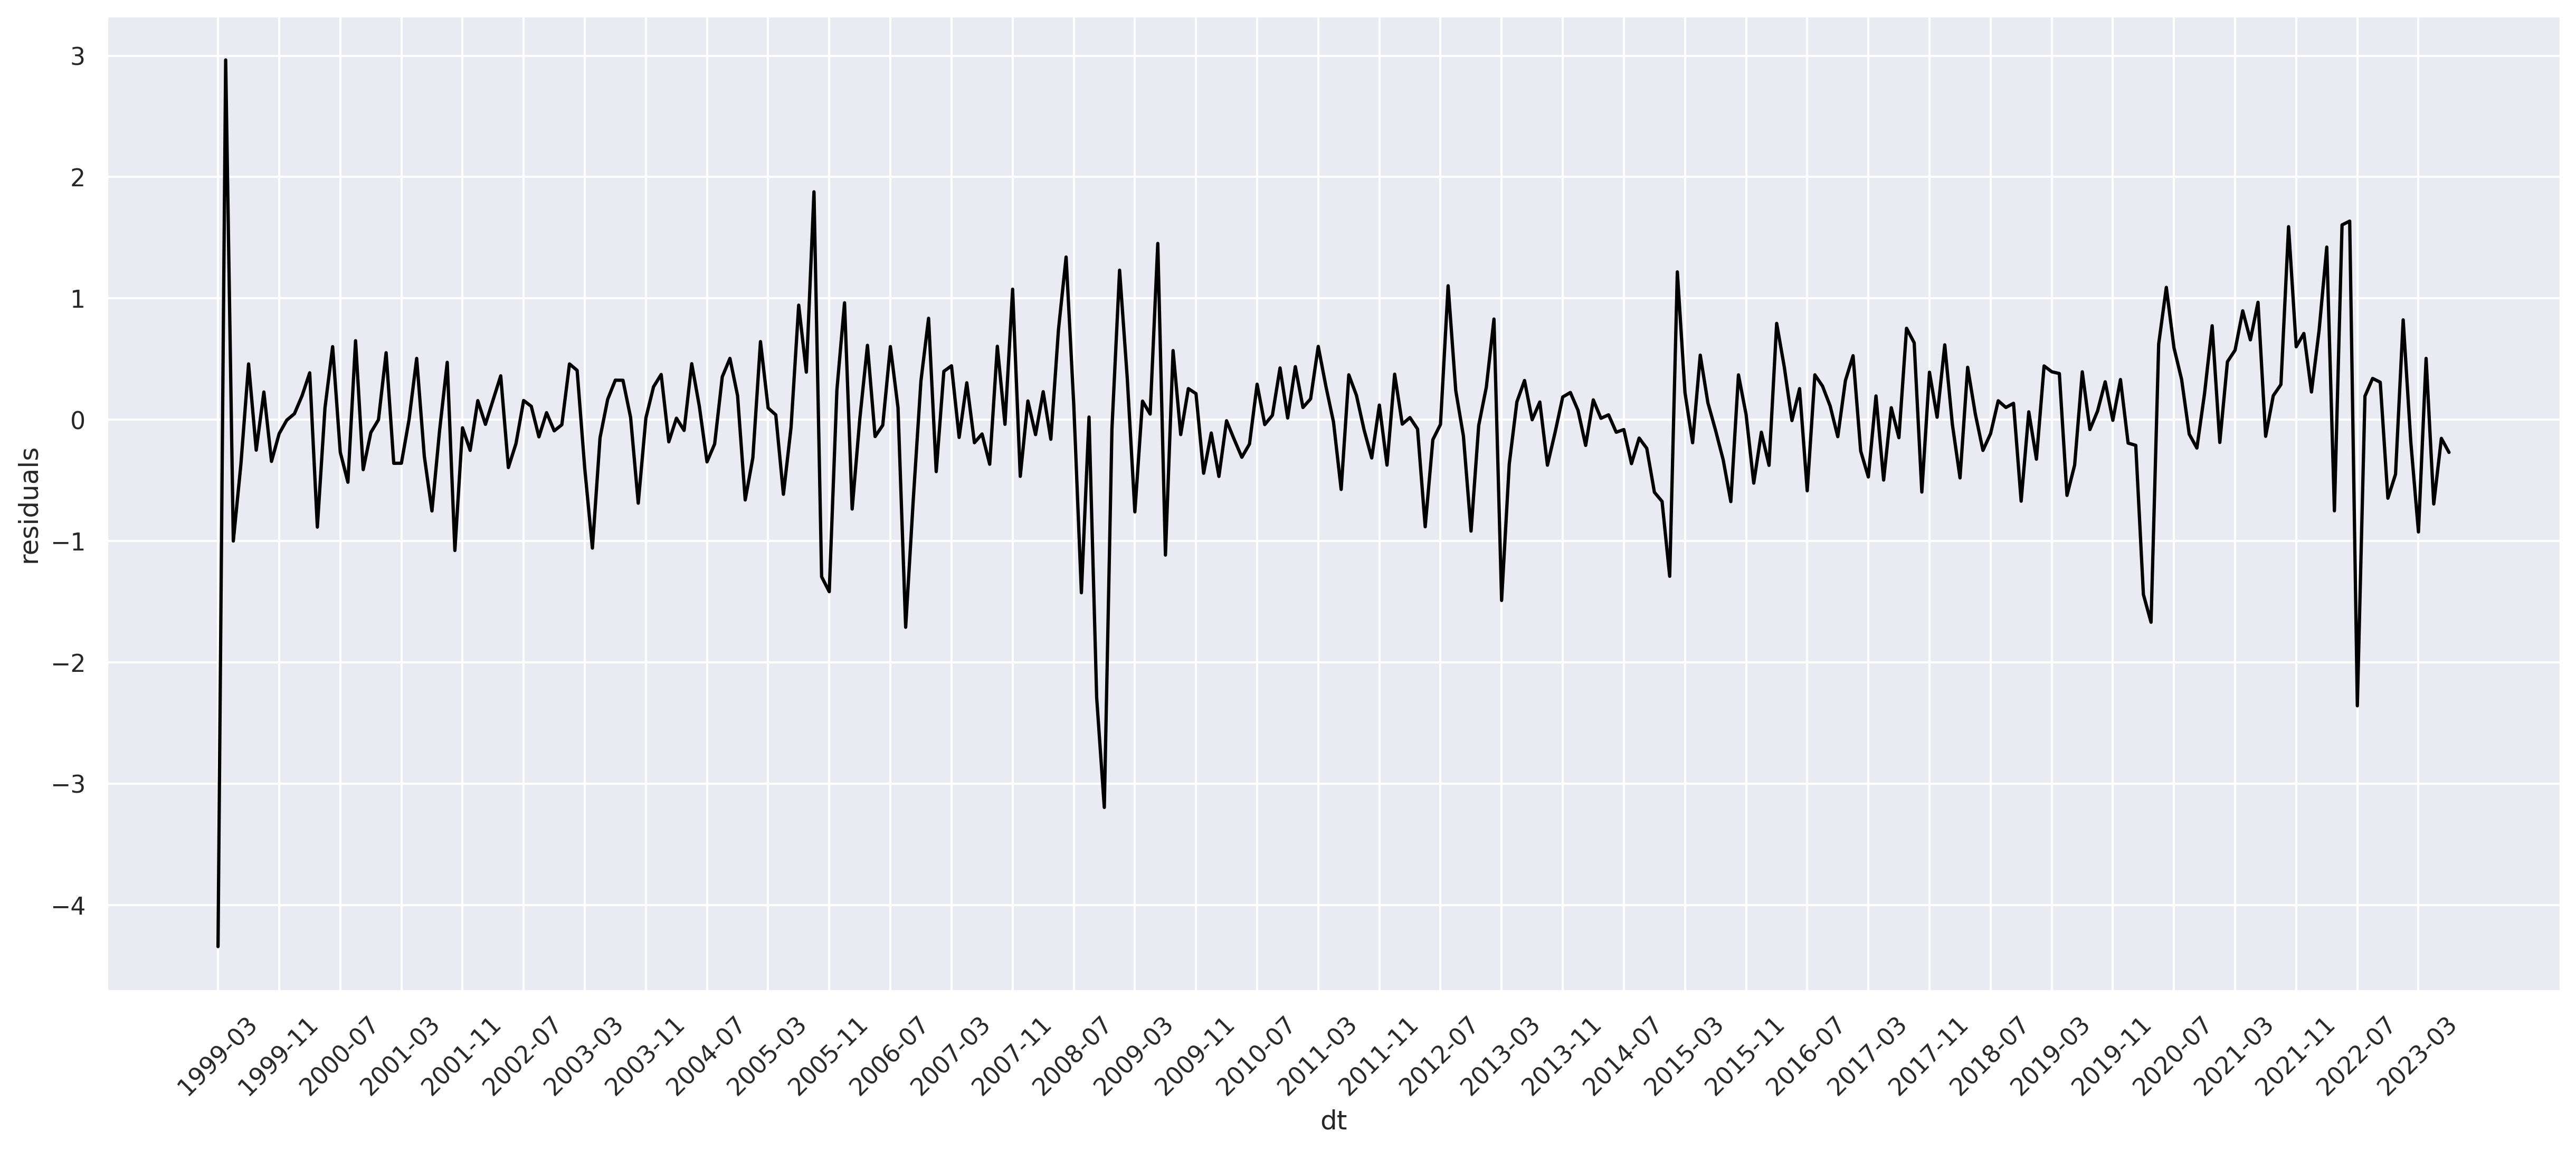

In [13]:
residuals = model.get_residuals()
plot(
    x=residuals.index.strftime("%Y-%m"), 
    y=residuals.values, 
    label='residuals'
)

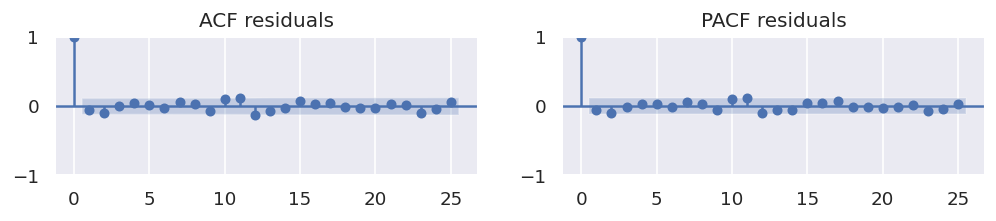

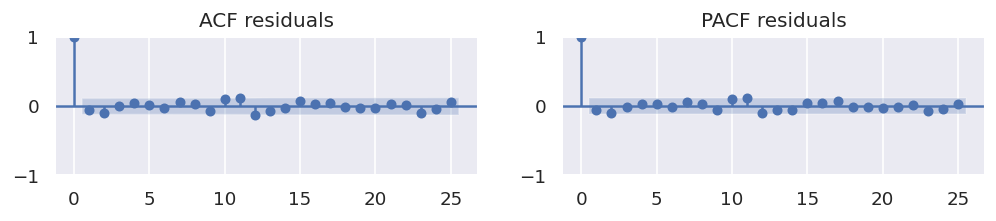

In [14]:
fig, axes = plt.subplots(1, 2, sharex=False)
sm.graphics.tsa.plot_acf(residuals, ax=axes[0], title=f"ACF residuals")
sm.graphics.tsa.plot_pacf(residuals, ax=axes[1], title=f"PACF residuals")

In [15]:
# Step 6 - Add exogenous variables
model2 = ARIMAModel(p=1, d=2, q=1)
model2.fit(
    y=dt.transform(y), 
    exog=processed_df.loc[:, [f"l_d_ln_{x}" for x in EXOG]]
)
model2.get_summary()

/home/marcin/miniconda3/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                  293
Model:                 ARIMA(1, 2, 1)   Log Likelihood                -260.180
Date:                Tue, 29 Aug 2023   AIC                            530.359
Time:                        18:53:28   BIC                            548.726
Sample:                    03-31-1999   HQIC                           537.717
                         - 07-31-2023                                         
Covariance Type:                  opg                                         
=====================================================================================
                        coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------
l_d_ln_FEDFUNDS       0.2942      0.178      1.650      0.099      -0.055       0.644
l_d_ln_MCOILWTICO     0.0155      0.004      4.212      0.000       0.008       0.023
ar.L1                 0.4530      0.045     10.169      0.000       0.366       0.540
ma.L1                -0.9598      0.014    -68.628      0.000      -0.987      -0.932
sigma2                0.3481      0.021     16.608      0.000       0.307       0.389
===================================================================================
Ljung-Box (L1) (Q):                   0.20   Jarque-Bera (JB):               149.86
Prob(Q):                              0.65   Prob(JB):                         0.00
Heteroskedasticity (H):               1.59   Skew:                            -0.62
Prob(H) (two-sided):                  0.02   Kurtosis:                         6.29
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""